In [276]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from tensorflow import keras
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from torchvision import models
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None


# Features

In [277]:
import sys
root = '../'
sys.path.append(root)

In [278]:
X_train = np.load( "/Users/kristiansjorslevnielsen/Documents/DVP7/Features/X_hpo_Cifar.npy" ) # Shape = (40000, 4096)
y_train = np.load("/Users/kristiansjorslevnielsen/Documents/DVP7/Features/y_hpo_Cifar.npy" ) # Shape = (40000,)
#X_val = np.load("/Users/kristiansjorslevnielsen/Documents/DVP7/Features/cifar10/val_features_vgg16_cifar10.npy" ) # Shape = (40000, 4096)
#y_val = np.load("/Users/kristiansjorslevnielsen/Documents/DVP7/Features/cifar10/val_labels_vgg16_cifar10.npy" ) # Shape = (40000,)
X_test = np.load("/Users/kristiansjorslevnielsen/Documents/DVP7/Features/X_val_Cifar.npy" ) # Shape = (10000, 4096)
y_test = np.load("/Users/kristiansjorslevnielsen/Documents/DVP7/Features/y_val_Cifar.npy" ) # Shape = (10000,)

In [279]:
y_test.shape

(500,)

In [280]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

In [281]:
#X_val = X_train[-5000:,:]
#X_train = X_train[:-5000,:]
#y_val = y_train[-5000:]
#y_train = y_train[:-5000]

In [282]:
#np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\train_features_vgg16_cifar10.npy', X_train)
#np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\val_features_vgg16_cifar10.npy', X_val)
#np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\train_labels_vgg16_cifar10.npy', y_train)
#np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\val_labels_vgg16_cifar10.npy', y_val)

# PCA

In [283]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Standardize the data
X_test = scaler.transform(X_test)

In [284]:
pca = PCA(n_components=100)  # Set the number of components to keep
training_features = pca.fit_transform(X_train)  # Fit PCA on the standardized data and transform
test_features = pca.transform(X_test)

# Spectral

In [285]:
def calculate_top_k_distances(anchors, data_points, k=20):
    # Convert anchors and data_points to numpy arrays for easy computation
    anchors = np.array(anchors)
    data_points = np.array(data_points)
    top_k_distances = np.zeros((data_points.shape[0], k))
    top_k_indices = np.zeros((data_points.shape[0], k), dtype=int)

    for i, data_point in enumerate(data_points):
        # Compute Euclidean distances between this data point and all anchors
        distances = np.sqrt(np.sum((anchors - data_point) ** 2, axis=1))

        k_smallest_indices = np.argpartition(distances, k)[:k]
        k_smallest_distances = distances[k_smallest_indices]
        sorted_indices = np.argsort(k_smallest_distances)
        top_k_distances[i] = k_smallest_distances[sorted_indices]
        top_k_indices[i] = k_smallest_indices[sorted_indices]

    return top_k_distances, top_k_indices


In [286]:
def anchor_adjecency(data, n_anchors, s, t):
    # Step 1: Anchor selection using k-means
    kmeans = KMeans(n_clusters=n_anchors, random_state=42)
    kmeans.fit(data)
    anchors = kmeans.cluster_centers_  # Get the anchor points

    Z = np.zeros([data.shape[0], n_anchors])
    dist,indices = calculate_top_k_distances(anchors, data, k=s)

    for i in tqdm(range(data.shape[0])):
        for j, index in enumerate(indices[i]):
            top = np.exp(-dist[i][j]/t)
            bottom = 0
            for k in range(indices.shape[1]):
                bottom += np.exp(-dist[i][k]/t)
            Z[i,index] = top/bottom

    L = (1/np.sqrt(Z.sum(axis=0)))*np.identity(Z.shape[1])

    M = L @ Z.T @ Z @ L

    return M, Z, L

In [287]:
M, Z, L = anchor_adjecency(training_features, n_anchors= 50, s=5, t=1)


100%|██████████| 5000/5000 [00:00<00:00, 29591.95it/s]


In [288]:
bits = 33
eigenvalues, eigenvectors = eigsh(M, k=bits,which="LM") # overvej max_iter, tolerance?

In [289]:
eigenvalues = eigenvalues[:-1]
eigenvectors = eigenvectors[:,:-1]

In [290]:
S = np.flip(1/np.sqrt(eigenvalues))*np.identity(eigenvalues.shape[0])
V = eigenvectors

In [291]:
Y = np.sqrt(training_features.shape[0]) * Z @ L @ V @ S

In [292]:
threshold1 = 0
eigenvectors_bin = np.where(Y > threshold1, 1, 0)

In [293]:
eigenvectors_bin.shape

(5000, 32)

In [294]:
np.unique(eigenvectors_bin, return_counts=True, axis=0)

(array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([1, 1, 3, ..., 1, 2, 1]))

# Classifier

In [295]:
clf = MLPClassifier(hidden_layer_sizes=(100), max_iter = 1000).fit(training_features, eigenvectors_bin)
test_hashes = clf.predict(test_features)

In [296]:
def mean_average_precision(test_hashes, training_hashes, test_labels, training_labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [297]:
def p_at_k(test_hashes, training_hashes, test_labels, training_labels, compare_n, ks):
    k_dic = {k:[] for k in ks}
    training_hashes = training_hashes[:compare_n,:]
    training_labels = training_labels[:compare_n]
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        for k in ks:
            df_temp = hash_df[:k]
            patk = df_temp["tp"].sum()/k
            k_dic[k].append(patk)
    return tuple([np.array(k_dic[k]).mean() for k in ks])

In [298]:
def average_pr_curve(precision_list, recall_list, num_points=100):
    recall_levels = np.linspace(0, 1, num_points)
    interpolated_precisions = []
    for precision, recall in zip(precision_list, recall_list):
        sorted_indices = np.argsort(recall)
        recall_sorted = recall[sorted_indices]
        precision_sorted = precision[sorted_indices]
        interpolated_precision = np.interp(recall_levels, recall_sorted, precision_sorted, left=0, right=0)
        interpolated_precisions.append(interpolated_precision)
    avg_precision = np.mean(interpolated_precisions, axis=0)
    return recall_levels, avg_precision

def interpolated_pr_curve(test_hashes, training_hashes, test_labels, training_labels):
    precision_list = []
    recall_list = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        recall = np.array(hash_df["tp"]) / np.array(hash_df["tp"].max())
        precision_list.append(precision)
        recall_list.append(recall)

    recall_levels, avg_precision = average_pr_curve(precision_list, recall_list)
    
    return recall_levels, avg_precision

In [299]:
test_hashes.shape

(500, 32)

In [300]:
recall, precision = interpolated_pr_curve(test_hashes, eigenvectors_bin, y_test, y_train)

100%|██████████| 500/500 [00:00<00:00, 519.65it/s]


In [301]:
def one_hot_encode(a):
    b = np.zeros((a.size, a.max() + 1))
    b[np.arange(a.size), a] = 1
    return b

def p_at_dist(test_hashes, training_hashes, test_labels, training_labels, dists):
    k_dic = {k:[] for k in dists}
    if len(training_labels.shape) == 1:
        training_labels = one_hot_encode(training_labels)
        test_labels = one_hot_encode(test_labels)
    for i, test_hash in tqdm(enumerate(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where((training_labels*label).sum(axis=1)>0, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        for k in dists:
            df_temp = hash_df[hash_df["distances"]<=k]
            patk = df_temp["tp"].sum()/df_temp.shape[0] if df_temp.shape[0]>0 else 0
            k_dic[k].append(patk)
    return tuple([np.array(k_dic[k]).mean() for k in dists])

In [302]:
def query(test_hash, training_hashes):
    distances = np.abs(training_hashes - test_hash).sum(axis=1)
    hash_df = pd.DataFrame({"distances":distances}).reset_index()
    hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
    return hash_df

In [303]:
query(test_hashes[1], eigenvectors_bin)["distances"].value_counts()

distances
16    808
18    729
17    711
15    545
14    487
19    410
20    313
13    206
12    147
11    146
21     97
22     78
3      59
9      58
7      47
24     41
10     31
6      28
8      26
23     23
4       5
25      3
5       2
Name: count, dtype: int64

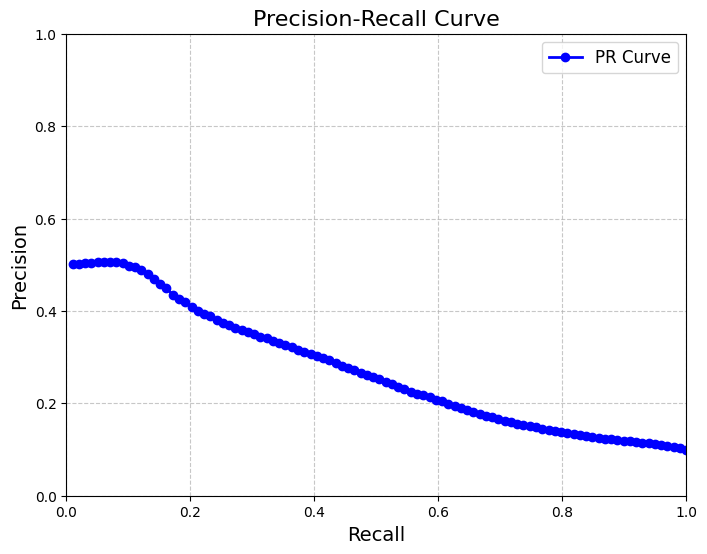

In [304]:
plt.figure(figsize=(8, 6))
plt.plot(recall[1:], precision[1:], marker='o', label='PR Curve', color='blue', linewidth=2)

# Adding labels, title, and grid
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)

# Show the plot
plt.show()

In [305]:
aps = mean_average_precision(test_hashes, eigenvectors_bin, y_test, y_train)
aps

100%|██████████| 500/500 [00:00<00:00, 533.86it/s]


0.2762953102447666

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

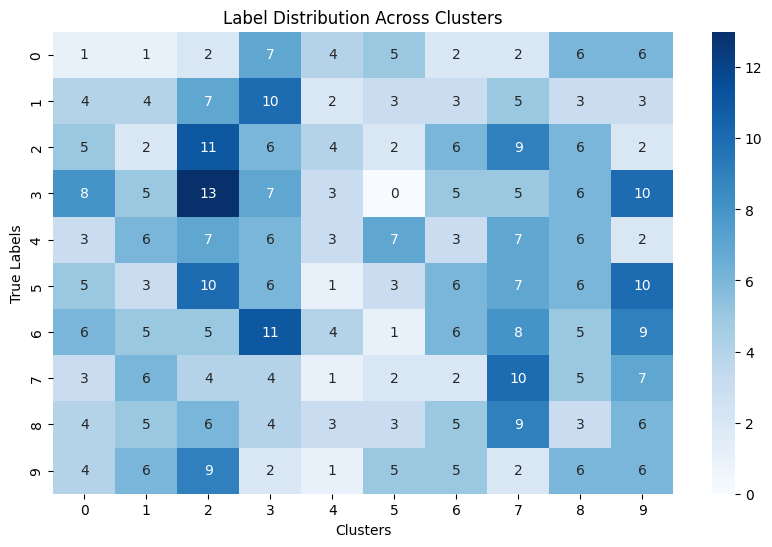

In [307]:
easyHeatmap(test_hashes, y_train)